In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [3]:
from regime_tickers import custom_volatility_subset

In [4]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = custom_volatility_subset + ['SPY'],  # add SPY for market reference
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [5]:
pd.set_option('display.max_rows', 300)
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())
print(df_adj.pivot(columns="symbol").isna().sum())

pd.reset_option('display.max_rows')

Total NANs: 0
             symbol
open         DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
high         DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
low          DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
close        DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
volume       DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
trade_count  DBC       0
             GLD       0
             HYG       0
             IWM

In [6]:
############## windows = [5, 20, 60]
windows = [20]

In [7]:
# Calculate Average True Range (ATR) normalized by close price
def compute_atr_per_symbol(group, windows=windows):
    for w in windows:
        atr = ta.volatility.AverageTrueRange(
            high=group['high'], 
            low=group['low'], 
            close=group['close'], 
            window=w
        )
        group[f'atr_norm_{w}'] = atr.average_true_range()
        
        # Normalize ATR using 'adj_close' if available, otherwise use 'close'
        group[f'atr_norm_{w}'] = group[f'atr_norm_{w}'] / group['close']

    return group

# Reapply to your DataFrame
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)

C:\Users\sergi\AppData\Local\Temp\ipykernel_16280\3889345209.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)


In [8]:
# Calculate Daily Log Returns
df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [9]:
z_window = 60

In [10]:
# Rolling Standard Deviation (Volatility). For further computations, later we will use z-scores of these values only
for w in windows:
    df_adj[f'rolling_std_{w}'] = df_adj.groupby('symbol')['log_returns'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )

    df_adj[f'z_rolling_std_{w}'] = df_adj.groupby('symbol')[f'rolling_std_{w}'].transform(
        lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std()
    )

In [11]:
# Range Ratio (High - Low) / Close, per asset
df_adj['range_ratio'] = (df_adj['high'] - df_adj['low']) / df_adj['close']
# Adding smoothing (e.g., rolling average of 5 days)
df_adj['range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio'].transform(lambda x: x.rolling(5).mean())
# Standardizing with Z-scores for regime shift detection
df_adj['z_range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio_smooth'].transform(lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std())

df_adj.drop(columns=['range_ratio', 'range_ratio_smooth'], inplace=True)

In [12]:
# Volatility Shock Count
# The number of days in a recent lookback window where daily returns exceeded 2 standard deviations, either up or down.
# It captures the frequency of abnormal moves — a key indicator for risk, panic clusters, or momentum bursts.

# 1. Calculate return z-scores per symbol
df_adj['z_log_returns'] = df_adj.groupby('symbol')['log_returns'].transform(
    lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
)

# 2. Count shocks in rolling window (e.g., abs(z) > 2 over last 20 days)
df_adj['vol_shock_count_20'] = df_adj.groupby('symbol')['z_log_returns'].transform(
    lambda x: x.rolling(20).apply(lambda r: (abs(r) > 2).sum(), raw=True)
)

df_adj.drop(columns=['log_returns'], inplace=True)

In [13]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [14]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('close', 'QQQ') -> 'close_QQQ'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [15]:
# Volatility Cross-Asset Dispersion lets you measure how much the volatility levels themselves are diverging across assets. It's like saying: are
#  all sectors jittery together or are some calm while others are chaotic? Great for reading the market’s internal stress or divergence.

# Step 1: Filter only the 'rolling_std_20' columns
rolling_std_cols = [col for col in df_pivot.columns if col.startswith('rolling_std_20_')]

# Step 2: Compute cross-sectional std (dispersion) across symbols for each timestamp
vol_dispersion = df_pivot[rolling_std_cols].std(axis=1)

# Step 3: Add back into df_pivot as a new column
df_pivot['volatility_dispersion'] = vol_dispersion

In [16]:
# Realized Vol / Implied Vol compares actual historical price movement (realized vol) with what the market expects (implied vol). 
# A ratio >1 means realized volatility has exceeded market expectations — a sign of surprise, dislocation, or a catch-up in pricing. 
# A ratio <1 suggests implied vol is elevated — often in times of uncertainty or hedging demand.

# Z-realized vs Implied Volatility Ratios

# Reference realized vol
realized = df_pivot['rolling_std_20_IWM']

# Loop over each implied asset and compute z-scored realized/implied ratios
implied = df_pivot['rolling_std_20_VIXY']
ratio = realized / implied
z_col = f'z_realized_implied_vixy'

df_pivot[z_col] = (ratio - ratio.rolling(z_window).mean()) / ratio.rolling(z_window).std()


In [17]:
# Volatility Spread = VIXY implied vol proxy – realized vol of SPY/IWM
# Z-score Level	What It Means
# > +2	Implied vol (VIXY) is much higher than realized vol → Fear spike
# < -2	Realized vol is unusually high vs what’s priced in → Complacency mispricing?
# Around 0	Implied and realized vol are in sync → Stable regime

# Step 1: Compute average realized vol of SPY and IWM
realized_avg = df_pivot[['rolling_std_20_SPY', 'rolling_std_20_IWM']].mean(axis=1)

# Step 2–4: Loop over implied assets to compute z-scored spread and clean up
spread = df_pivot['rolling_std_20_VIXY'] - realized_avg
z_col = f'z_vol_spread_vixy'

df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [18]:
# Volatility Skew = Difference in realized vol between two symbols
# QQQ vs SPY — Big Tech vs Broad Market - IWM vs SPY — Small Caps vs Broad Market - GLD vs SPY — Gold vs Broad Market
# Define the assets to compare against SPY
skew_assets = ['QQQ', 'IWM', 'GLD']

# Loop to compute z-scored volatility skew vs SPY
for ticker in skew_assets:
    spread = df_pivot[f'rolling_std_20_{ticker}'] - df_pivot['rolling_std_20_SPY']
    z_col = f'z_vol_skew_{ticker.lower()}'
    
    df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [19]:
# volume ratios
df_pivot["vol_QQQ/vol_GLD"] = df_pivot['volume_QQQ'] / df_pivot['volume_GLD']

In [20]:
# elative volatility for each asset, market=SPY
for ticker in custom_volatility_subset:
    if ticker == 'SPY':
        continue  # Skip SPY as it's the market reference
    df_pivot[f'relative_vol_{ticker.lower()}'] = df_pivot[f'z_rolling_std_20_{ticker}'] / df_pivot['z_rolling_std_20_SPY']

    ## DROP??
    df_pivot.drop(columns=f'z_rolling_std_20_{ticker}', inplace=True)

In [21]:
# Drop 'SPY' columns to avoid redundancy, they where just used for comparison
df_pivot.drop(columns=[col for col in df_pivot.columns if 'SPY' in col], inplace=True)

# Drop 'rolling_std_20' columns to avoid redundancy, they where just used for comparison, we keep z-scores only
# Drop columns that start with 'rolling_std_20'
df_pivot.drop(columns=[col for col in df_pivot.columns if col.startswith("rolling_std_20")], inplace=True)

In [22]:
# after 2*max(windows) +z_window -1 days, not nans
print(df_pivot[max(windows)+z_window-1:].isna().sum().sum()) 

df_pivot_clean = df_pivot[max(windows)+z_window-1:]

0


In [23]:
# # Check feature stationarity using Augmented Dickey-Fuller test
# # p-value > 0.1 = likely non-stationary (bad for PCA)
# from statsmodels.tsa.stattools import adfuller

# stationary_features = []
# for col in df_pivot_clean.columns:
#     result = adfuller(df_pivot_clean[col])
#     if result[1] < 0.1:
#         stationary_features.append(col)

# # print which features are stationary, to keep for PCA
# from collections import Counter
# prefixes = [ "_".join(v.split("_")[:-1]) for v in stationary_features ]
# print(Counter(prefixes))

# #df_stationary = df_pivot_clean[stationary_features]

In [24]:
df_stationary = df_pivot_clean.drop(
    columns=[col for col in df_pivot_clean.columns if any(x in col for x in ["vwap", "low", "high", "close", "open", "volume", "trade_count", "atr", "z_log_returns"])],
)

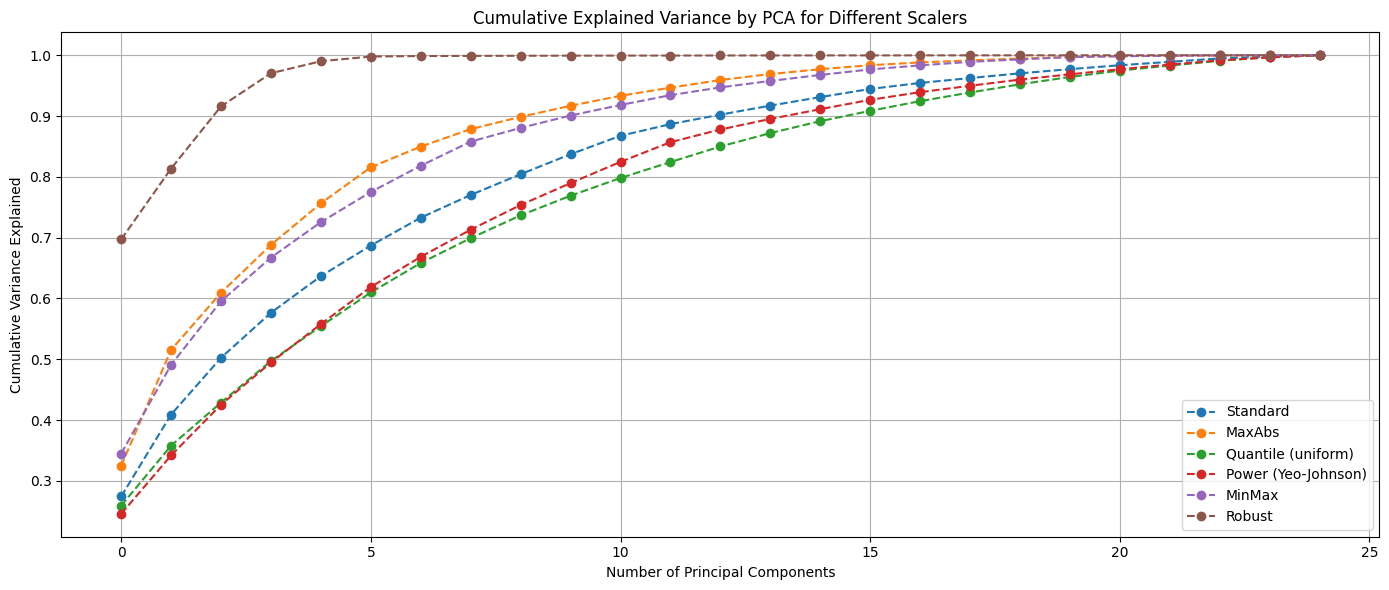

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare scalers in a dict for easy iteration
scalers = {
    "Standard": StandardScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
}

# Store cumulative variance per scaler
cum_variances = {}

for name, scaler in scalers.items():
    try:
        scaled = scaler.fit_transform(df_stationary)
        pca = PCA()
        X_pca = pca.fit_transform(scaled)
        cum_var = np.cumsum(pca.explained_variance_ratio_)
        cum_variances[name] = cum_var
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Plot all in one figure
plt.figure(figsize=(14, 6))

for name, cum_var in cum_variances.items():
    plt.plot(cum_var, marker='o', linestyle='--', label=name)

plt.title("Cumulative Explained Variance by PCA for Different Scalers")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


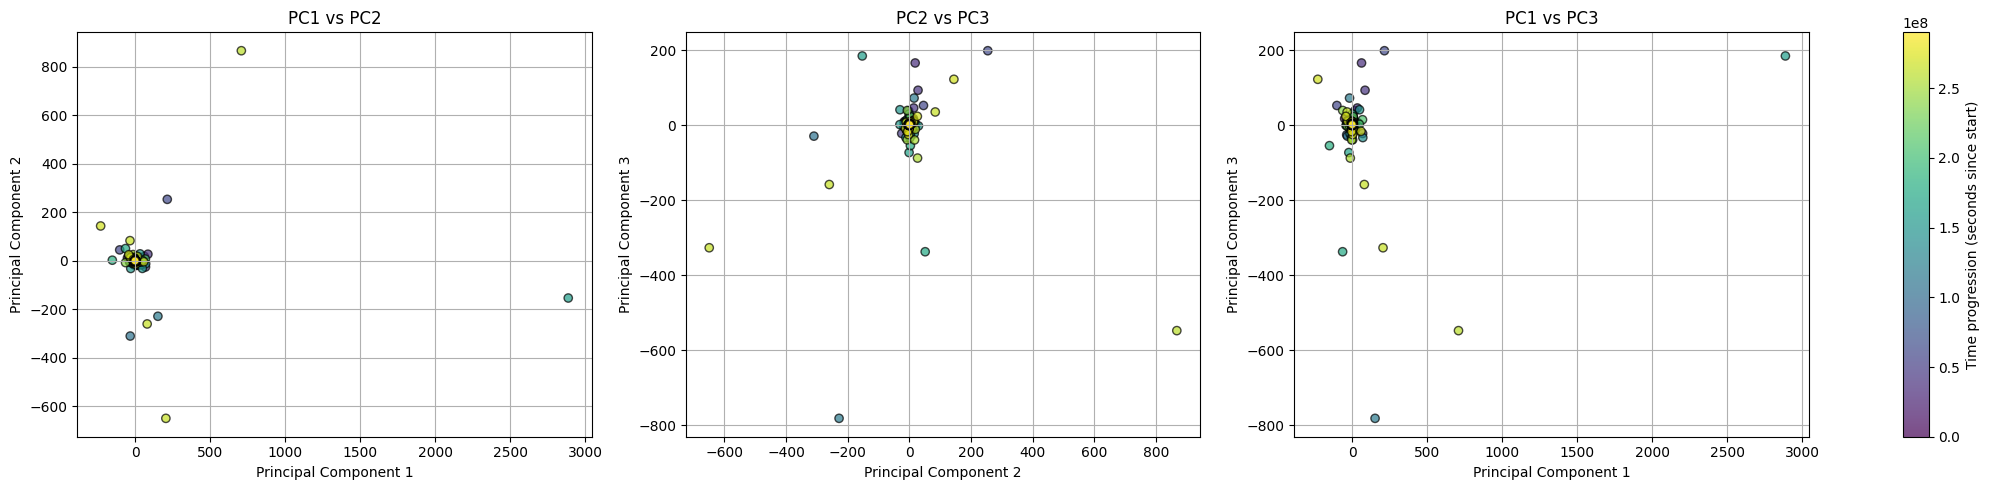

In [26]:
import matplotlib.gridspec as gridspec

# Convert timestamps to numeric
timestamps = pd.to_datetime(df_pivot_clean.index)
time_numeric = (timestamps - timestamps.min()).total_seconds()

# Set up figure with gridspec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

# Common colormap
cmap = plt.cm.viridis

# Plot 1: PC1 vs PC2
ax0 = plt.subplot(gs[0])
sc0 = ax0.scatter(X_pca[:, 0], X_pca[:, 1], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel("Principal Component 1")
ax0.set_ylabel("Principal Component 2")
ax0.grid(True)

# Plot 2: PC2 vs PC3
ax1 = plt.subplot(gs[1])
sc1 = ax1.scatter(X_pca[:, 1], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax1.set_title("PC2 vs PC3")
ax1.set_xlabel("Principal Component 2")
ax1.set_ylabel("Principal Component 3")
ax1.grid(True)

# Plot 3: PC1 vs PC3
ax2 = plt.subplot(gs[2])
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax2.set_title("PC1 vs PC3")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 3")
ax2.grid(True)

# Add a colorbar in the dedicated subplot
cax = plt.subplot(gs[3])
cb = plt.colorbar(sc2, cax=cax)
cb.set_label("Time progression (seconds since start)")

plt.tight_layout()
plt.show()


In [27]:
scaled = RobustScaler().fit_transform(df_stationary)
pca = PCA(n_components=0.99)  # Keep 80% of variance
X_pca = pca.fit_transform(scaled)

pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# --- Interpretation of Principal Components (PCA Loadings) ---
print("\n📊 PCA Component Loadings (Original Feature Contributions)\n")

# Create a nicely formatted DataFrame of loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=df_stationary.columns
)

# 🌈 Stylish display with rounded values and background gradient
loadings_styled = (
    loadings.style
    .format(precision=2)  # ✅ Ensures rounded display
    .background_gradient(cmap='coolwarm', axis=0)
    .set_caption("📊 PCA Component Loadings — Contribution of Original Features")
)

display(loadings_styled)


📊 PCA Component Loadings (Original Feature Contributions)



,PC1,PC2,PC3,PC4,PC5
z_range_ratio_smooth_DBC,0.00,-0.00,0.00,0.00,0.00
z_range_ratio_smooth_GLD,0.00,0.00,-0.00,-0.00,-0.00
z_range_ratio_smooth_HYG,0.00,0.00,0.00,-0.00,-0.00
z_range_ratio_smooth_IWM,-0.00,0.00,-0.00,-0.00,0.00
z_range_ratio_smooth_QQQ,0.00,0.00,-0.00,-0.00,-0.00
z_range_ratio_smooth_VIXY,0.00,0.00,0.00,-0.00,0.00
vol_shock_count_20_DBC,-0.00,-0.00,0.00,0.00,0.00
vol_shock_count_20_GLD,-0.00,0.00,0.00,-0.00,0.00
vol_shock_count_20_HYG,-0.00,0.00,0.00,0.00,-0.00
vol_shock_count_20_IWM,-0.00,0.00,0.00,0.00,-0.00


In [1]:
print("\n--- Explained Variance Ratio ---")
print(pca.explained_variance_ratio_)
print(f"Total variance explained by {X_pca.shape[1]} components: {pca.explained_variance_ratio_.sum():.2f}")


--- Explained Variance Ratio ---


NameError: name 'pca' is not defined

In [85]:

# --- 4. Perform K-Means Clustering on PCA data ---
# Let's choose 3 clusters for this example
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for modern KMeans
clusters = kmeans.fit_predict(X_pca)
pca_df['Cluster'] = clusters
df['Cluster'] = clusters # Add cluster labels to original df as well

print(f"\nCluster distribution across {n_clusters} clusters:")
print(pca_df['Cluster'].value_counts().sort_index())

# --- 5. Interpret the Meaning of the Clusters ---

print("\n--- Cluster Interpretation ---")

# A. Analyze Cluster Centroids in PCA Space
print("\nPCA Cluster Centroids:")
pca_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['PC1', 'PC2'])
print(pca_centroids)

# Plot clusters in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('Clusters in PCA Space')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% explained)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% explained)')
plt.legend()
plt.grid(True)
plt.show()

# B. Analyze Original Feature Means/Medians within Each Cluster
print("\nOriginal Feature Means per Cluster:")
cluster_means = df.groupby('Cluster').mean()
print(cluster_means)

print("\nOriginal Feature Medians per Cluster:")
cluster_medians = df.groupby('Cluster').median() # Medians can be robust to outliers
print(cluster_medians)

# Visualize original feature distributions per cluster (e.g., using box plots)
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.drop('Cluster', axis=1).columns):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of features
    sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')
    plt.title(f'{column} by Cluster')
plt.tight_layout()
plt.show()

# C. Summarize and Name Clusters
print("\n--- Summary of Cluster Characteristics & Proposed Names ---")

# Based on the PCA loadings, PC1 likely relates to purchase activity/value, and PC2 to engagement type.

for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    print("PCA Centroid:")
    print(pca_centroids.loc[i])
    print("\nOriginal Feature Means (for Cluster " + str(i) + "):")
    print(cluster_means.loc[i])

    # Now, interpret based on both PCA centroid and original feature means
    # Example Interpretation (will vary based on random data generation):
    if i == 0:
        print("\nProposed Name: 'High-Value Engaged Customers'")
        print("Description: Generally high income, many purchases, high average order value, high online engagement, but moderate customer service interactions.")
    elif i == 1:
        print("\nProposed Name: 'Budget-Conscious Online Browsers'")
        print("Description: Lower income, fewer purchases, smaller average order value, but still decent online engagement. Might contact customer service less.")
    elif i == 2:
        print("\nProposed Name: 'Moderate Spenders, Higher Support Needs'")
        print("Description: Average income, moderate purchases and order value, but potentially lower online engagement and higher customer service interactions.")

    # These descriptions are illustrative and would be derived by *you* examining the output.
    # Look for:
    # - Which PC has a high/low value for this cluster?
    # - How do the *original feature means* for this cluster compare to the overall average and other clusters?
    # - What story do these characteristics tell?

NameError: name 'KMeans' is not defined

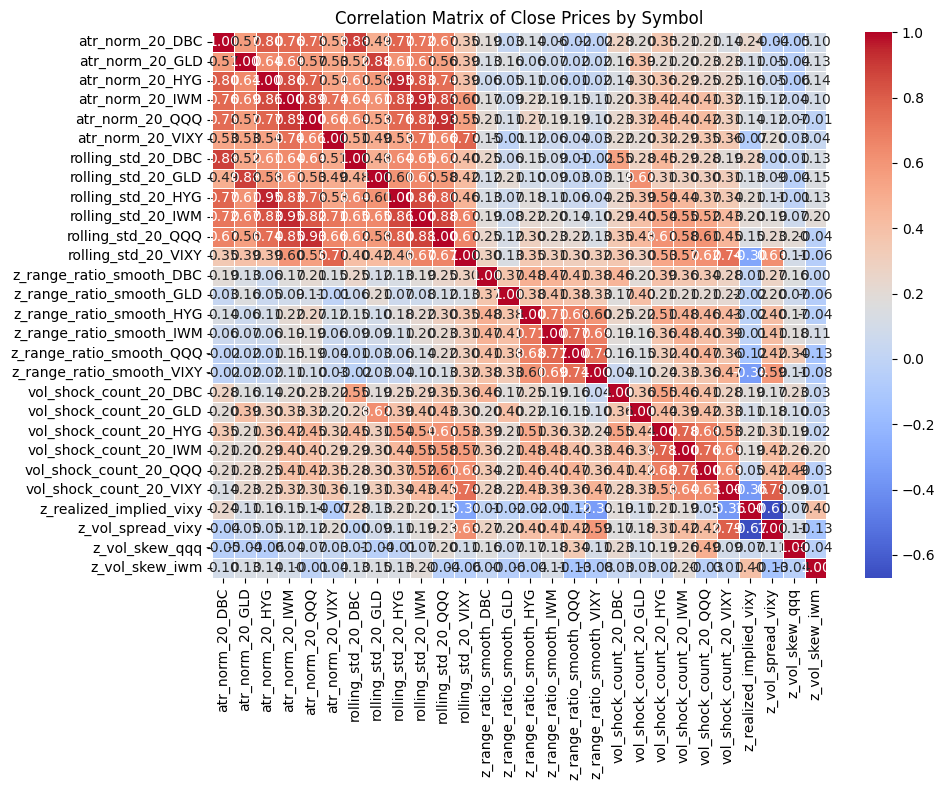

In [ ]:
## BUSCAR UN GRUPO QUE NO TENGA UNA CORRELACION ALTA?????

# # # ##### Correlation Heatmap #####
import seaborn as sns
import matplotlib.pyplot as plt


# Optionally drop rows with missing values to ensure clean correlation
corr_df = df_stationary.dropna()

# Compute the correlation matrix
correlation_matrix = corr_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Close Prices by Symbol")
plt.tight_layout()
plt.show()


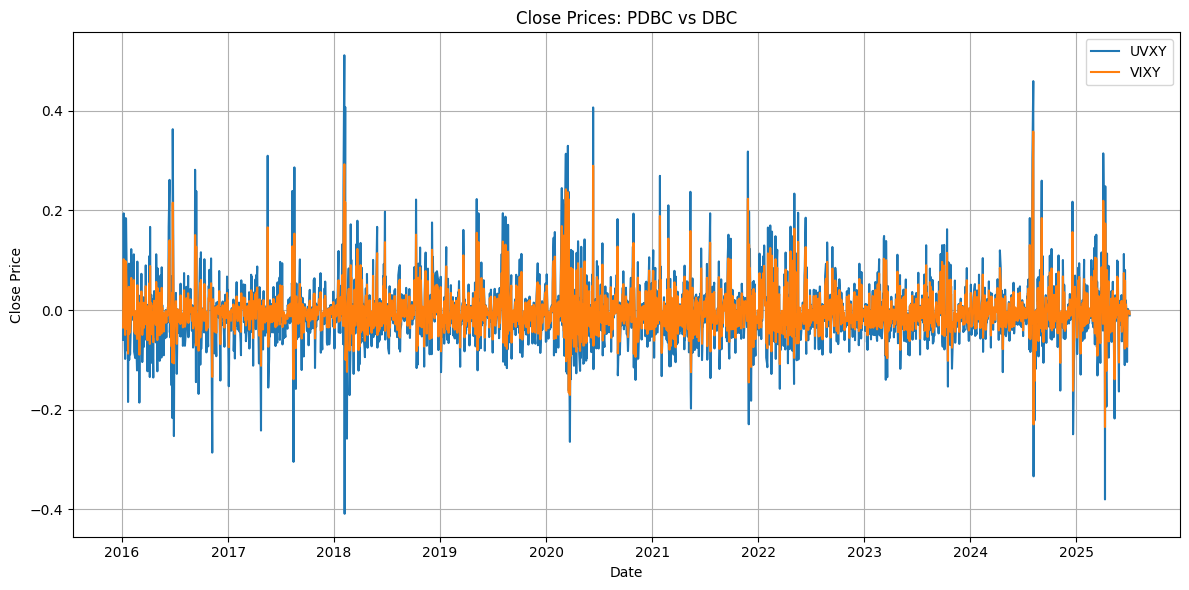

In [ ]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for symbol in ['UVXY', 'VIXY']:
    subset = df_adj[df_adj['symbol'] == symbol]
    ax.plot(subset.index, subset['log_returns'], label=symbol)

ax.set_title('Close Prices: PDBC vs DBC')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
